In [1]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay

# Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#CSV import for crashes table
filepath = "Datasets/crash_records_ml.csv"
df = pd.read_csv(filepath)
df.head()

,Make,Model,Model Year,Incident Date,Incident Time (24:00),City,State,Roadway Type,Roadway Surface,Roadway Description,Posted Speed Limit (MPH),Lighting,Clear,Snow,Cloudy,Fog/Smoke,Rain,Severe Wind,Injuries,Passengers Belted
0,Jaguar,I-Pace,2021,January 2024,12:04,Los Angeles,CA,Street,Dry,No Unusual Conditions,25.0,Daylight,1,0,0,0,0,0,1,0
1,Jaguar,I-Pace,2024,July 2024,04:58,San Francisco,CA,Street,Dry,No Unusual Conditions,25.0,Dark - Lighted,1,0,0,0,0,0,0,0
2,Jaguar,I-Pace,2024,July 2024,11:29,Phoenix,AZ,Parking Lot,Dry,No Unusual Conditions,5.0,Daylight,1,0,0,0,0,0,0,1
3,Jaguar,I-Pace,2024,July 2024,18:16,San Francisco,CA,Street,Dry,No Unusual Conditions,25.0,Daylight,1,0,0,0,0,0,0,0
4,Jaguar,I-Pace,2024,July 2024,11:06,Austin,TX,Street,Dry,No Unusual Conditions,40.0,Daylight,0,0,1,0,0,0,0,1


In [4]:
df = df.dropna()

In [5]:
df.columns

Index(['Make', 'Model', 'Model Year', 'Incident Date', 'Incident Time (24:00)',
       'City', 'State', 'Roadway Type', 'Roadway Surface',
       'Roadway Description', 'Posted Speed Limit (MPH)', 'Lighting', 'Clear',
       'Snow', 'Cloudy', 'Fog/Smoke', 'Rain', 'Severe Wind', 'Injuries',
       'Passengers Belted'],
      dtype='object')

In [6]:
cols_to_drop= ['City', 'State','Make','Model', 'Incident Date','Roadway Description','Incident Date','Lighting']
df_ml = df.drop(cols_to_drop, axis=1)
df_ml.head()

,Model Year,Incident Time (24:00),Roadway Type,Roadway Surface,Posted Speed Limit (MPH),Clear,Snow,Cloudy,Fog/Smoke,Rain,Severe Wind,Injuries,Passengers Belted
0,2021,12:04,Street,Dry,25.0,1,0,0,0,0,0,1,0
1,2024,04:58,Street,Dry,25.0,1,0,0,0,0,0,0,0
2,2024,11:29,Parking Lot,Dry,5.0,1,0,0,0,0,0,0,1
3,2024,18:16,Street,Dry,25.0,1,0,0,0,0,0,0,0
4,2024,11:06,Street,Dry,40.0,0,0,1,0,0,0,0,1


In [7]:
def categorize_time(incident_time): #X-pert advised
    if isinstance(incident_time, str):
        if "00:00" <= incident_time < "10:00":
            return "Morning"
        elif "10:00" <= incident_time <= "16:00":
            return "Afternoon"
        else:
            return "Evening / Night"
    else:
        return None  # or return a default value, e.g., "Unknown"

# Apply the function to the Incident Time column
df_ml['Incident Time (24:00)'] = df_ml['Incident Time (24:00)'].apply(categorize_time)

In [8]:
df_ml['Incident Time (24:00)'].value_counts()

Incident Time (24:00)
Evening / Night    472
Afternoon          451
Morning            405
Name: count, dtype: int64

In [9]:
df_ml = df_ml.rename(columns = {'Incident Time (24:00)': "Time of Day"})
df_ml['Time of Day'].value_counts()

Time of Day
Evening / Night    472
Afternoon          451
Morning            405
Name: count, dtype: int64

In [10]:
df_ml = df_ml.rename(columns = {'Posted Speed Limit (MPH)': "Speed Limit"})
df_ml['Speed Limit'] = df_ml['Speed Limit'].astype(int)


In [11]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1328 entries, 0 to 1361
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Model Year         1328 non-null   int64 
 1   Time of Day        1328 non-null   object
 2   Roadway Type       1328 non-null   object
 3   Roadway Surface    1328 non-null   object
 4   Speed Limit        1328 non-null   int32 
 5   Clear              1328 non-null   int64 
 6   Snow               1328 non-null   int64 
 7   Cloudy             1328 non-null   int64 
 8   Fog/Smoke          1328 non-null   int64 
 9   Rain               1328 non-null   int64 
 10  Severe Wind        1328 non-null   int64 
 11  Injuries           1328 non-null   int64 
 12  Passengers Belted  1328 non-null   int64 
dtypes: int32(1), int64(9), object(3)
memory usage: 140.1+ KB


In [12]:
df_ml.head()

,Model Year,Time of Day,Roadway Type,Roadway Surface,Speed Limit,Clear,Snow,Cloudy,Fog/Smoke,Rain,Severe Wind,Injuries,Passengers Belted
0,2021,Afternoon,Street,Dry,25,1,0,0,0,0,0,1,0
1,2024,Morning,Street,Dry,25,1,0,0,0,0,0,0,0
2,2024,Afternoon,Parking Lot,Dry,5,1,0,0,0,0,0,0,1
3,2024,Evening / Night,Street,Dry,25,1,0,0,0,0,0,0,0
4,2024,Afternoon,Street,Dry,40,0,0,1,0,0,0,0,1


In [13]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1328 entries, 0 to 1361
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Model Year         1328 non-null   int64 
 1   Time of Day        1328 non-null   object
 2   Roadway Type       1328 non-null   object
 3   Roadway Surface    1328 non-null   object
 4   Speed Limit        1328 non-null   int32 
 5   Clear              1328 non-null   int64 
 6   Snow               1328 non-null   int64 
 7   Cloudy             1328 non-null   int64 
 8   Fog/Smoke          1328 non-null   int64 
 9   Rain               1328 non-null   int64 
 10  Severe Wind        1328 non-null   int64 
 11  Injuries           1328 non-null   int64 
 12  Passengers Belted  1328 non-null   int64 
dtypes: int32(1), int64(9), object(3)
memory usage: 140.1+ KB


In [14]:
df_ml.describe()

,Model Year,Speed Limit,Clear,Snow,Cloudy,Fog/Smoke,Rain,Severe Wind,Injuries,Passengers Belted
count,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.0,1328.000000,1328.0,1328.000000,1328.000000
mean,2069.266566,29.847892,0.827560,0.000753,0.128012,0.0,0.033133,0.0,0.197289,0.648343
std,617.564092,12.588295,0.377905,0.027441,0.334229,0.0,0.179050,0.0,0.398102,0.477667
min,2016.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
25%,2021.000000,25.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
50%,2021.000000,25.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.000000
75%,2023.000000,30.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.000000
max,9999.000000,75.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000


In [15]:
# corrs = df_ml.corr()
# corrs

ValueError: could not convert string to float: 'Afternoon'

In [ ]:
# plt.figure(figsize=(10,6))
# sns.heatmap(corrs, annot=True)
# plt.show()

In [ ]:
# abs(corrs.Injuries).sort_values(ascending=False)

In [ ]:
# #  Dropping the columns with no positive results for the period that was covered by this report.
# #  May need to re-instate as more incidents come up
# cols_to_drop= ['Severe Wind', 'Fog/Smoke']
# df_ml = df_ml.drop(cols_to_drop, axis=1)
# df_ml.head()

In [ ]:
# corrs = df_ml.corr()
# corrs

In [ ]:
# plt.figure(figsize=(10,6))
# sns.heatmap(corrs, annot=True)
# plt.show()

In [ ]:
# abs(corrs.Injuries).sort_values(ascending=False)

In [21]:
features = ['Model Year', 'Time of Day', 'Roadway Type', 'Roadway Surface',
       'Speed Limit', 'Clear', 'Snow', 'Cloudy', 'Rain', 'Passengers Belted']

# We are looking to see if Injuries are resultant from various characteristics, as a result "Injuries" was dropped from the features as it'll be against our test case.

In [ ]:
# # SCALE the NUMERIC Features FIRST

# # subset
# df_sub = df_ml.loc[:, features]

# # initialize
# scaler = StandardScaler()

# # fit
# scaler.fit(df_sub)

# # predict/transform
# scaled_data = scaler.transform(df_sub)
# df_scaled = pd.DataFrame(scaled_data, columns=features)

# df_scaled.head()

In [ ]:
# df_scaled.describe()

In [ ]:
# # Step 1: Get the data
# X = df_scaled
# y = df_ml.Injuries

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
df_ml.columns

Index(['Model Year', 'Time of Day', 'Roadway Type', 'Roadway Surface',
       'Speed Limit', 'Clear', 'Snow', 'Cloudy', 'Fog/Smoke', 'Rain',
       'Severe Wind', 'Injuries', 'Passengers Belted'],
      dtype='object')

In [26]:
## Need  to do a classificiation model

# Define Preprocessing Pipelines

# Define preprocessing for numeric features (Age, Fare, Family_Size) (note that for age, we just use the column median, not split by gender)
numeric_features = ['Model Year', 'Speed Limit'] # You can also do this in a loop, select the numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])
    # ('scaler', StandardScaler())])

# # Define preprocessing for the binary features ('CryoSleep', 'VIP', 'Side')
binary_features = ['Clear', 'Snow', 'Cloudy', 'Fog/Smoke', 'Rain',
       'Severe Wind', 'Injuries', 'Passengers Belted']
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('label', OrdinalEncoder())])  # Label encode for binary feature

# # Define preprocessing for categorical features ('HomePlanet', 'Destination', 'Deck') 
categorical_features = ['Time of Day', 'Roadway Type', 'Roadway Surface']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# # Combine preprocessing for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('binary', binary_transformer, binary_features),
        ('cat', categorical_transformer, categorical_features)])

In [29]:
# Use only preprocessing pipeline to transform the data
preprocessed_X_train = preprocessor.fit_transform(df_ml)

# Convert preprocessed data to a DataFrame
# Get the feature names after one-hot encoding
encoded_feature_names = (numeric_features + binary_features +
                         list(preprocessor.transformers_[2][1]['onehot'].get_feature_names_out(categorical_features)))

df_final = pd.DataFrame(preprocessed_X_train, columns=encoded_feature_names)
df_final["Injuries"] = df.Injuries
df_final.head()

,Model Year,Speed Limit,Clear,Snow,Cloudy,Fog/Smoke,Rain,Severe Wind,Injuries,Passengers Belted,Time of Day_Afternoon,Time of Day_Evening / Night,Time of Day_Morning,Roadway Type_Highway / Freeway,Roadway Type_Intersection,Roadway Type_Parking Lot,Roadway Type_Street,Roadway Type_Traffic Circle,Roadway Type_Unknown,Roadway Surface_Dry,Roadway Surface_Snow / Slush / Ice,Roadway Surface_Unknown,Roadway Surface_Wet
0,2021.0,25.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2024.0,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2024.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2024.0,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2024.0,40.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [31]:
corrs = df_final.corr()
corrs

,Model Year,Speed Limit,Clear,Snow,Cloudy,Fog/Smoke,Rain,Severe Wind,Injuries,Passengers Belted,Time of Day_Afternoon,Time of Day_Evening / Night,Time of Day_Morning,Roadway Type_Highway / Freeway,Roadway Type_Intersection,Roadway Type_Parking Lot,Roadway Type_Street,Roadway Type_Traffic Circle,Roadway Type_Unknown,Roadway Surface_Dry,Roadway Surface_Snow / Slush / Ice,Roadway Surface_Unknown,Roadway Surface_Wet
Model Year,1.000000,-0.068551,0.009522,-0.002102,-0.000476,NaN,-0.014296,NaN,0.010375,-0.004817,0.046315,-0.037253,-0.008913,-0.021814,-0.030424,0.122332,-0.008782,-0.004886,-0.002974,0.017844,-0.003005,-0.004409,-0.016946
Speed Limit,-0.068551,1.000000,-0.134621,0.011239,0.163143,NaN,0.013940,NaN,0.035418,0.268441,0.101795,-0.052785,-0.049833,0.828161,-0.162614,-0.267479,-0.168636,-0.004142,0.077627,-0.006887,0.000469,-0.021176,0.012657
Clear,0.009522,-0.134621,1.000000,-0.060138,-0.833400,NaN,-0.405532,NaN,-0.002492,-0.077354,-0.059895,0.055771,0.003629,-0.189184,0.079189,0.014462,0.009917,0.028062,0.017728,0.459428,-0.033676,-0.084036,-0.452116
Snow,-0.002102,0.011239,-0.060138,1.000000,-0.010518,NaN,-0.005082,NaN,0.055999,0.020217,0.038280,-0.020384,-0.018184,-0.007791,-0.024545,-0.006023,0.031608,-0.001688,-0.001066,-0.119093,0.706840,-0.001509,-0.006023
Cloudy,-0.000476,0.163143,-0.833400,-0.010518,1.000000,NaN,-0.020558,NaN,0.012526,0.083933,0.115489,-0.063200,-0.053090,0.217323,-0.047750,-0.030240,-0.050510,-0.023555,-0.014880,-0.107331,-0.014880,0.020069,0.109722
Fog/Smoke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rain,-0.014296,0.013940,-0.405532,-0.005082,-0.020558,NaN,1.000000,NaN,-0.050359,-0.031078,-0.035027,-0.014403,0.051003,0.011531,-0.055444,-0.040618,0.068676,-0.011380,-0.007189,-0.803090,-0.007189,-0.010175,0.843660
Severe Wind,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Injuries,0.010375,0.035418,-0.002492,0.055999,0.012526,NaN,-0.050359,NaN,1.000000,0.043819,-0.009191,0.004838,0.004437,0.020700,0.005631,-0.008028,-0.019582,0.031607,0.029843,0.053409,0.055999,0.007292,-0.064694
Passengers Belted,-0.004817,0.268441,-0.077354,0.020217,0.083933,NaN,-0.031078,NaN,0.043819,1.000000,0.201791,-0.019828,-0.186954,0.209025,0.071340,-0.071935,-0.156738,0.019526,0.028602,0.003163,0.028602,0.040480,-0.019202


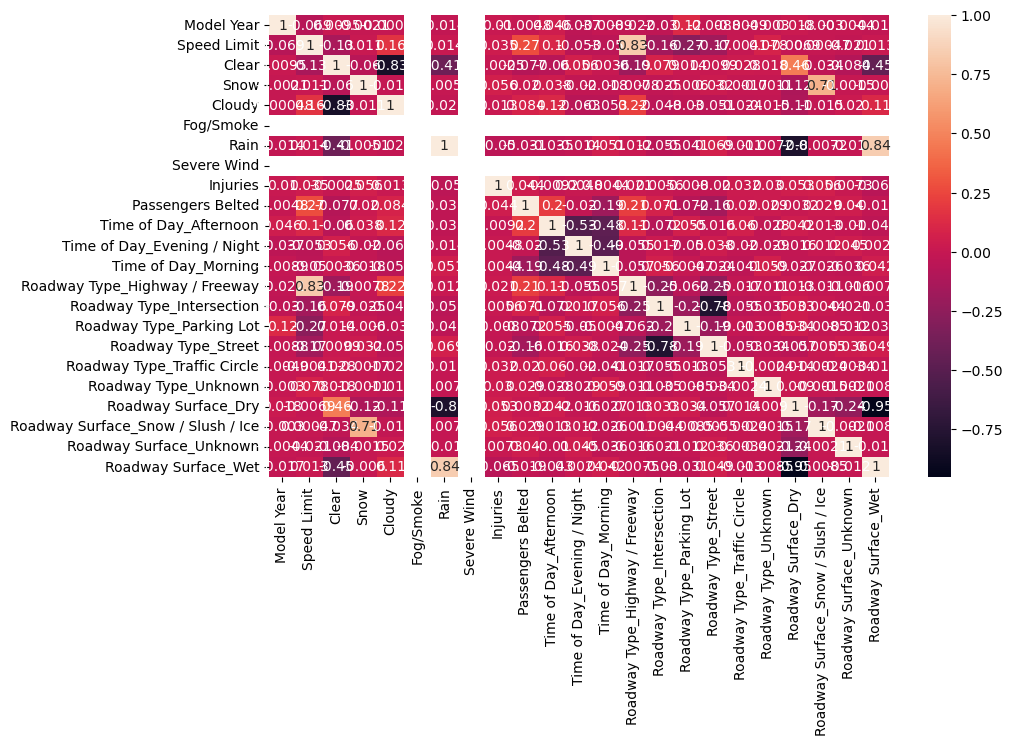

In [32]:
plt.figure(figsize=(10,6))
sns.heatmap(corrs, annot=True)
plt.show()

In [33]:
abs(corrs.Injuries).sort_values(ascending=False)

Injuries                              1.000000
Roadway Surface_Wet                   0.064694
Roadway Surface_Snow / Slush / Ice    0.055999
Snow                                  0.055999
Roadway Surface_Dry                   0.053409
Rain                                  0.050359
Passengers Belted                     0.043819
Speed Limit                           0.035418
Roadway Type_Traffic Circle           0.031607
Roadway Type_Unknown                  0.029843
Roadway Type_Highway / Freeway        0.020700
Roadway Type_Street                   0.019582
Cloudy                                0.012526
Model Year                            0.010375
Time of Day_Afternoon                 0.009191
Roadway Type_Parking Lot              0.008028
Roadway Surface_Unknown               0.007292
Roadway Type_Intersection             0.005631
Time of Day_Evening / Night           0.004838
Time of Day_Morning                   0.004437
Clear                                 0.002492
Fog/Smoke    

In [34]:
#  Dropping the columns with no positive results for the period that was covered by this report.
#  May need to re-instate as more incidents come up
cols_to_drop= ['Severe Wind', 'Fog/Smoke']
df_final = df_final.drop(cols_to_drop, axis=1)
df_final.head()

,Model Year,Speed Limit,Clear,Snow,Cloudy,Rain,Injuries,Passengers Belted,Time of Day_Afternoon,Time of Day_Evening / Night,Time of Day_Morning,Roadway Type_Highway / Freeway,Roadway Type_Intersection,Roadway Type_Parking Lot,Roadway Type_Street,Roadway Type_Traffic Circle,Roadway Type_Unknown,Roadway Surface_Dry,Roadway Surface_Snow / Slush / Ice,Roadway Surface_Unknown,Roadway Surface_Wet
0,2021.0,25.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2024.0,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2024.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2024.0,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2024.0,40.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [35]:
corrs = df_final.corr()
corrs

,Model Year,Speed Limit,Clear,Snow,Cloudy,Rain,Injuries,Passengers Belted,Time of Day_Afternoon,Time of Day_Evening / Night,Time of Day_Morning,Roadway Type_Highway / Freeway,Roadway Type_Intersection,Roadway Type_Parking Lot,Roadway Type_Street,Roadway Type_Traffic Circle,Roadway Type_Unknown,Roadway Surface_Dry,Roadway Surface_Snow / Slush / Ice,Roadway Surface_Unknown,Roadway Surface_Wet
Model Year,1.000000,-0.068551,0.009522,-0.002102,-0.000476,-0.014296,0.010375,-0.004817,0.046315,-0.037253,-0.008913,-0.021814,-0.030424,0.122332,-0.008782,-0.004886,-0.002974,0.017844,-0.003005,-0.004409,-0.016946
Speed Limit,-0.068551,1.000000,-0.134621,0.011239,0.163143,0.013940,0.035418,0.268441,0.101795,-0.052785,-0.049833,0.828161,-0.162614,-0.267479,-0.168636,-0.004142,0.077627,-0.006887,0.000469,-0.021176,0.012657
Clear,0.009522,-0.134621,1.000000,-0.060138,-0.833400,-0.405532,-0.002492,-0.077354,-0.059895,0.055771,0.003629,-0.189184,0.079189,0.014462,0.009917,0.028062,0.017728,0.459428,-0.033676,-0.084036,-0.452116
Snow,-0.002102,0.011239,-0.060138,1.000000,-0.010518,-0.005082,0.055999,0.020217,0.038280,-0.020384,-0.018184,-0.007791,-0.024545,-0.006023,0.031608,-0.001688,-0.001066,-0.119093,0.706840,-0.001509,-0.006023
Cloudy,-0.000476,0.163143,-0.833400,-0.010518,1.000000,-0.020558,0.012526,0.083933,0.115489,-0.063200,-0.053090,0.217323,-0.047750,-0.030240,-0.050510,-0.023555,-0.014880,-0.107331,-0.014880,0.020069,0.109722
Rain,-0.014296,0.013940,-0.405532,-0.005082,-0.020558,1.000000,-0.050359,-0.031078,-0.035027,-0.014403,0.051003,0.011531,-0.055444,-0.040618,0.068676,-0.011380,-0.007189,-0.803090,-0.007189,-0.010175,0.843660
Injuries,0.010375,0.035418,-0.002492,0.055999,0.012526,-0.050359,1.000000,0.043819,-0.009191,0.004838,0.004437,0.020700,0.005631,-0.008028,-0.019582,0.031607,0.029843,0.053409,0.055999,0.007292,-0.064694
Passengers Belted,-0.004817,0.268441,-0.077354,0.020217,0.083933,-0.031078,0.043819,1.000000,0.201791,-0.019828,-0.186954,0.209025,0.071340,-0.071935,-0.156738,0.019526,0.028602,0.003163,0.028602,0.040480,-0.019202
Time of Day_Afternoon,0.046315,0.101795,-0.059895,0.038280,0.115489,-0.035027,-0.009191,0.201791,1.000000,-0.532504,-0.475024,0.111258,-0.071582,0.055325,-0.015790,0.059764,-0.027850,0.041799,0.013153,-0.010400,-0.043417
Time of Day_Evening / Night,-0.037253,-0.052785,0.055771,-0.020384,-0.063200,-0.014403,0.004838,-0.019828,-0.532504,1.000000,-0.491882,-0.055025,0.016785,-0.050207,0.038306,-0.019962,-0.028839,-0.015718,0.011731,0.045312,0.002399


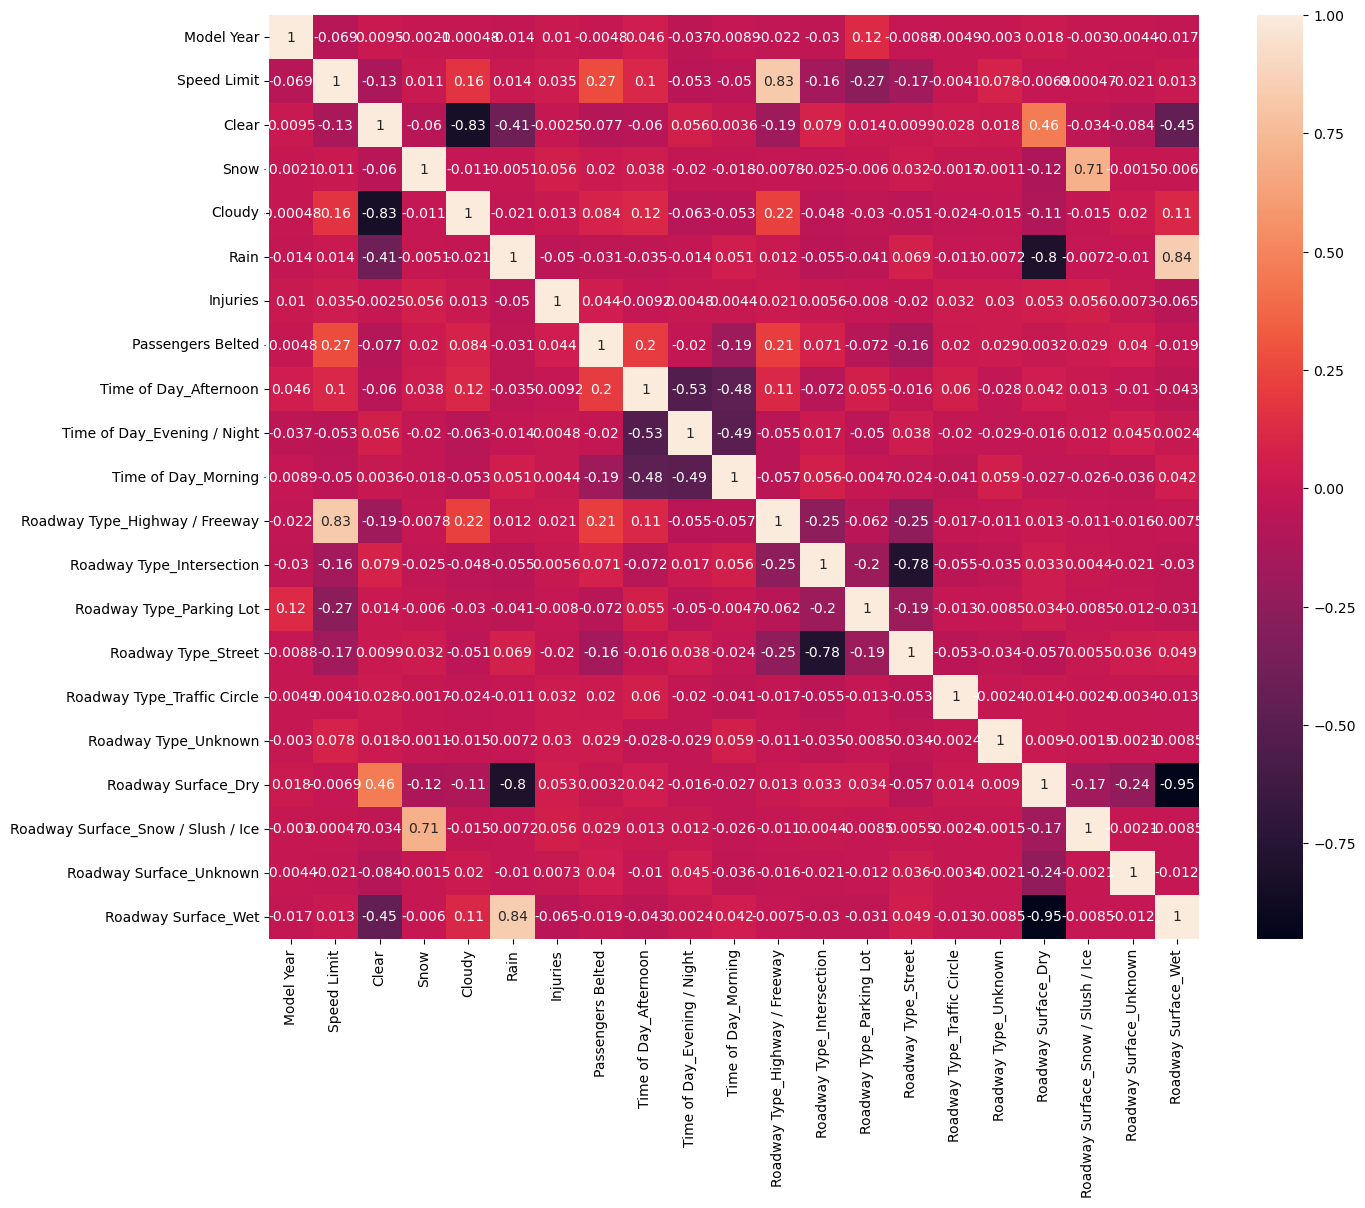

In [40]:
plt.figure(figsize=(15,12))
sns.heatmap(corrs, annot=True)
plt.show()

In [37]:
abs(corrs.Injuries).sort_values(ascending=False)

Injuries                              1.000000
Roadway Surface_Wet                   0.064694
Roadway Surface_Snow / Slush / Ice    0.055999
Snow                                  0.055999
Roadway Surface_Dry                   0.053409
Rain                                  0.050359
Passengers Belted                     0.043819
Speed Limit                           0.035418
Roadway Type_Traffic Circle           0.031607
Roadway Type_Unknown                  0.029843
Roadway Type_Highway / Freeway        0.020700
Roadway Type_Street                   0.019582
Cloudy                                0.012526
Model Year                            0.010375
Time of Day_Afternoon                 0.009191
Roadway Type_Parking Lot              0.008028
Roadway Surface_Unknown               0.007292
Roadway Type_Intersection             0.005631
Time of Day_Evening / Night           0.004838
Time of Day_Morning                   0.004437
Clear                                 0.002492
Name: Injurie

In [ ]:
X = df.drop(columns=["Transported", "PassengerId"])
y = df.Transported

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y) # stratify=True maintains target class percentages
print(X_train.shape, X_test.shape)

In [30]:
def doClassification(model, X_train, X_test, y_train, y_test):
    # Step 3: Fit the model
    model.fit(X_train, y_train)
    
    # Step 4: Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    # Generate metrics TRAIN
    train_cf = confusion_matrix(y_train, train_preds)
    train_cr = classification_report(y_train, train_preds)
    train_auc = roc_auc_score(y_train, train_proba)
    
    train_results = f"""TRAIN METRICS
    Confusion Matrix: 
    {train_cf}
    
    AUC: {train_auc}

    Classification Report:
    {train_cr}
    """
    
    print(train_results)

    # Generate metrics TEST
    test_cf = confusion_matrix(y_test, test_preds)
    test_cr = classification_report(y_test, test_preds)
    test_auc = roc_auc_score(y_test, test_proba)
    
    test_results = f"""TEST METRICS
    Confusion Matrix: 
    {test_cf}
    
    AUC: {test_auc}

    Classification Report:
    {test_cr}
    """
    
    print(test_results)

    # VISUALIZE TEST RESULTS
    # Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(test_cf, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test.values, test_proba)
    
    # Set figure size
    plt.figure(figsize=(6, 6))
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.2f})')
    
    # Plot the diagonal reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    
    # Titles and labels
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Add grid and legend
    plt.grid(linestyle="--", color="lightgrey", alpha=0.75)
    plt.legend(loc="lower right")
    
    # Display the plot
    plt.show()